In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
file_path = "../data/cleaned_data.csv"

# Load the file using the pipe delimiter
df = pd.read_csv(file_path )

In [4]:
import numpy as np
from datetime import datetime

# Convert VehicleIntroDate to datetime
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')

# Create VehicleAge
current_year = 2015  # Based on your dataset end date (Aug 2015)
df['VehicleAge'] = current_year - df['VehicleIntroDate'].dt.year

# Drop VehicleIntroDate if you won't use it anymore
df.drop(columns=['VehicleIntroDate'], inplace=True)


In [8]:
# Select numeric and categorical features
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=np.number).columns

# One-hot encode categoricals
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [9]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['TotalClaims'])
y = df_encoded['TotalClaims']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
high_card_cols = ['Bank', 'CapitalOutstanding', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone']

df_reduced = df.drop(columns=high_card_cols)


In [9]:
categorical_cols_in_df = [col for col in categorical_cols if col in df_reduced.columns]
print(categorical_cols_in_df)


['TransactionMonth', 'Citizenship', 'LegalType', 'Title', 'Language', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype', 'AlarmImmobiliser', 'TrackingDevice', 'NewVehicle', 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']


In [10]:
df_encoded_sparse = pd.get_dummies(df_reduced, columns=categorical_cols_in_df, sparse=True)


In [15]:
df_encoded_sparse = pd.get_dummies(df_reduced, columns=categorical_cols_in_df, dtype="Sparse[int]")


In [21]:
print(df_encoded_sparse.dtypes)


UnderwrittenCoverID                                      int64
PolicyID                                                 int64
IsVATRegistered                                           bool
mmcode                                                 float64
RegistrationYear                                         int64
                                                    ...       
Product_Mobility Commercial Cover: Monthly    Sparse[int64, 0]
Product_Mobility Metered Taxis: Monthly       Sparse[int64, 0]
Product_Standalone Passenger Liability        Sparse[int64, 0]
StatutoryClass_Commercial                     Sparse[int64, 0]
StatutoryRiskType_IFRS Constant               Sparse[int64, 0]
Length: 644, dtype: object


In [11]:
for col in df_encoded_sparse.columns:
    if not pd.api.types.is_sparse(df_encoded_sparse[col]):
        if df_encoded_sparse[col].dtype == 'uint8':  # typical dummy column dtype
            df_encoded_sparse[col] = pd.arrays.SparseArray(df_encoded_sparse[col])


In [17]:
for col in df_encoded_sparse.columns:
    if not pd.api.types.is_sparse(df_encoded_sparse[col]):
        df_encoded_sparse[col] = pd.arrays.SparseArray(df_encoded_sparse[col])


In [12]:
from scipy import sparse
X_sparse = sparse.csr_matrix(df_encoded_sparse.values)


In [13]:
categorical_cols = [
    'TransactionMonth', 'Citizenship', 'LegalType', 'Title', 'Language',
    'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
    'ItemType', 'VehicleType', 'make', 'Model', 'bodytype',
    'AlarmImmobiliser', 'TrackingDevice', 'NewVehicle',
    'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
    'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType'
]


In [14]:
from sklearn.preprocessing import OrdinalEncoder

# Copy df_reduced to avoid clobbering
df_enc = df_reduced.copy()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit & transform
df_enc[categorical_cols] = enc.fit_transform(df_enc[categorical_cols])


In [32]:
print(df_enc[categorical_cols].dtypes)
print(df_enc[categorical_cols].head())


TransactionMonth     float64
Citizenship          float64
LegalType            float64
Title                float64
Language             float64
AccountType          float64
MaritalStatus        float64
Gender               float64
Country              float64
Province             float64
ItemType             float64
VehicleType          float64
make                 float64
Model                float64
bodytype             float64
AlarmImmobiliser     float64
TrackingDevice       float64
NewVehicle           float64
TermFrequency        float64
ExcessSelected       float64
CoverCategory        float64
CoverType            float64
CoverGroup           float64
Section              float64
Product              float64
StatutoryClass       float64
StatutoryRiskType    float64
dtype: object
   TransactionMonth  Citizenship  LegalType  Title  Language  AccountType  \
0              17.0          0.0        0.0    2.0       0.0          0.0   
1              19.0          0.0        0.0    2.

In [15]:
# Features now include encoded categoricals and your numeric features (e.g., VehicleAge, cubiccapacity, kilowatts, CapitalOutstanding, etc.)
features = [col for col in df_enc.columns if col != 'TotalClaims']
X = df_enc[features]
y = df_enc['TotalClaims']


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"✅ XGBoost RMSE: {rmse:.2f}")
print(f"✅ X²: {r2:.3f}")


✅ XGBoost RMSE: 2479.10
✅ X²: -0.258


In [16]:
#Filter rows where TotalClaims > 0
# Filter only rows where TotalClaims > 0
df_claims = df_reduced[df_reduced['TotalClaims'] > 0].copy()

# Define features and target
X = df_claims.drop(['TotalClaims'], axis=1)
y = df_claims['TotalClaims']

# Encode categorical variables
categorical_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train_dt, y_train_dt)

# Predict
y_pred_dt = dt_model.predict(X_test_dt)

# Evaluate
rmse_dt = np.sqrt(mean_squared_error(y_test_dt, y_pred_dt))
r2_dt = r2_score(y_test_dt, y_pred_dt)

print(f"✅ Decision Tree RMSE: {rmse_dt:.2f}")
print(f"✅ Decision Tree R²: {r2_dt:.3f}")


✅ Decision Tree RMSE: 38891.79
✅ Decision Tree R²: 0.059


In [10]:
# Subset where claims exist
df_claims = df[df["TotalClaims"] > 0].copy()

# Define features and target
target = "TotalClaims"
features = df_claims.drop(columns=["TotalClaims", "TotalPremium"])  # drop target and premium if predicting only claims

# Split features into numerical and categorical
numerical_cols = features.select_dtypes(include=["number"]).columns
categorical_cols = features.select_dtypes(include=["object", "category"]).columns

# One-hot encode categorical features
df_encoded = pd.get_dummies(features, columns=categorical_cols, drop_first=True)

# Align target
y = df_claims[target]


In [11]:
from sklearn.model_selection import train_test_split

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    df_encoded, y, test_size=0.2, random_state=42
)


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

y_pred_rf = rf.predict(X_test_encoded)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"✅ Random Forest RMSE: {rmse_rf:.2f}")
print(f"✅ Random Forest R²: {r2_rf:.3f}")


✅ Random Forest RMSE: 36147.67
✅ Random Forest R²: 0.188


One-hot encoding the following columns in full dataset: ['Category_A', 'Category_B']

--- X_train_preprocessed info ---
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 55 to 51
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Numeric1                    80 non-null     float64
 1   Numeric2                    80 non-null     float64
 2   VehicleIntroDate_Year       80 non-null     int32  
 3   VehicleIntroDate_Month      80 non-null     int32  
 4   VehicleIntroDate_Day        80 non-null     int32  
 5   VehicleIntroDate_DayOfWeek  80 non-null     int32  
 6   Category_A_Y                80 non-null     bool   
 7   Category_A_Z                80 non-null     bool   
 8   Category_B_Q                80 non-null     bool   
dtypes: bool(3), float64(2), int32(4)
memory usage: 3.4 KB
None

--- X_test_preprocessed info ---
<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 

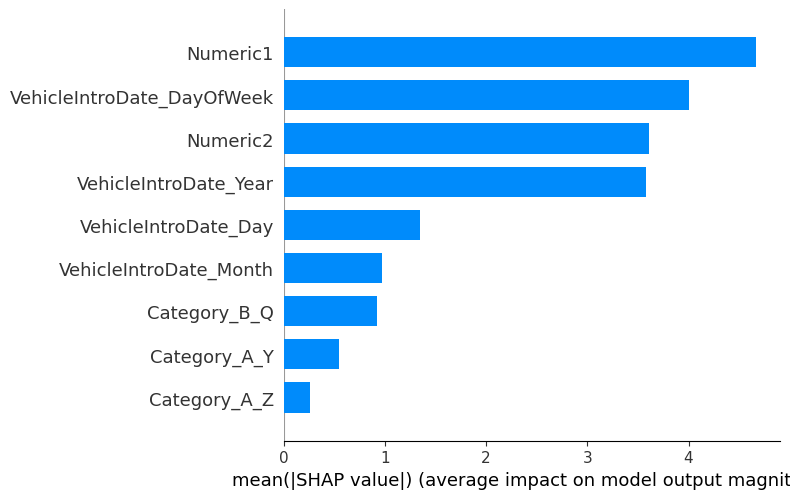


Top 5 important features by SHAP value:
Numeric1: 4.671
VehicleIntroDate_DayOfWeek: 4.007
Numeric2: 3.611
VehicleIntroDate_Year: 3.579
VehicleIntroDate_Day: 1.346


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # Or whatever your model is

# --- 1. Load your original, raw DataFrame (replace with your actual data loading) ---
# Example:
data = {
    'Numeric1': np.random.rand(100),
    'Numeric2': np.random.rand(100) * 10,
    'VehicleIntroDate': pd.to_datetime(pd.date_range(start='2010-01-01', periods=100, freq='M')),
    'Category_A': np.random.choice(['X', 'Y', 'Z'], 100),
    'Category_B': np.random.choice(['P', 'Q'], 100),
    'Target_Variable': np.random.rand(100) * 100
}
df_original = pd.DataFrame(data)

# Make sure 'VehicleIntroDate' is object type to simulate your earlier error
df_original['VehicleIntroDate'] = df_original['VehicleIntroDate'].astype(str)


# --- 2. Apply ALL preprocessing to the ENTIRE feature set FIRST ---

df_processed = df_original.copy() # Work on a copy

# Handle 'VehicleIntroDate'
df_processed['VehicleIntroDate'] = pd.to_datetime(df_processed['VehicleIntroDate'])
df_processed['VehicleIntroDate_Year'] = df_processed['VehicleIntroDate'].dt.year
df_processed['VehicleIntroDate_Month'] = df_processed['VehicleIntroDate'].dt.month
df_processed['VehicleIntroDate_Day'] = df_processed['VehicleIntroDate'].dt.day
df_processed['VehicleIntroDate_DayOfWeek'] = df_processed['VehicleIntroDate'].dt.dayofweek
df_processed = df_processed.drop('VehicleIntroDate', axis=1) # Drop original

# Handle other categorical columns
# Assuming 'Category_A' and 'Category_B' are your original categorical columns
# You can identify them programmatically:
categorical_cols_to_encode = df_processed.select_dtypes(include='object').columns.tolist()
if categorical_cols_to_encode:
    print(f"One-hot encoding the following columns in full dataset: {categorical_cols_to_encode}")
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, drop_first=True)
else:
    print("No additional categorical columns to one-hot encode in full dataset.")


# --- 3. Separate features (X) and target (y) from the FULLY PROCESSED DataFrame ---
X = df_processed.drop('Target_Variable', axis=1) # Replace 'Target_Variable' with your actual target column name
y = df_processed['Target_Variable']

# --- 4. Split the PROCESSED data into training and testing sets ---
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- X_train_preprocessed info ---")
print(X_train_preprocessed.info())
print("\n--- X_test_preprocessed info ---")
print(X_test_preprocessed.info())


# --- 5. Train your Random Forest model ---
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_preprocessed, y_train)

print("\nModel trained successfully.")

# --- NOW, your SHAP calculation code can use X_test_preprocessed directly ---
# (And it no longer needs the column alignment logic, as it's handled by the single preprocessing pipeline)

import shap

# Initialize the TreeExplainer with your trained Random Forest model
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for your processed test data
# Use X_test_preprocessed here
shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar")

# Compute mean absolute SHAP values per feature
if isinstance(shap_values, list):
    mean_abs_shap = np.abs(shap_values[0]).mean(axis=0)
else:
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Get top 5 features
top_indices = np.argsort(mean_abs_shap)[::-1][:5]
top_features = X_test_preprocessed.columns[top_indices]
top_importances = mean_abs_shap[top_indices]

print("\nTop 5 important features by SHAP value:")
for feat, imp in zip(top_features, top_importances):
    print(f"{feat}: {imp:.3f}")

In [24]:
import shap

# Create a TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(model)

# Compute SHAP values on a sample to reduce memory use
X_sample = X_test.sample(n=500, random_state=42)  # sample 500 rows
shap_values = explainer.shap_values(X_sample)

# Get feature names
feature_names = X_sample.columns


In [7]:
import numpy
print(numpy.__version__)

1.26.4


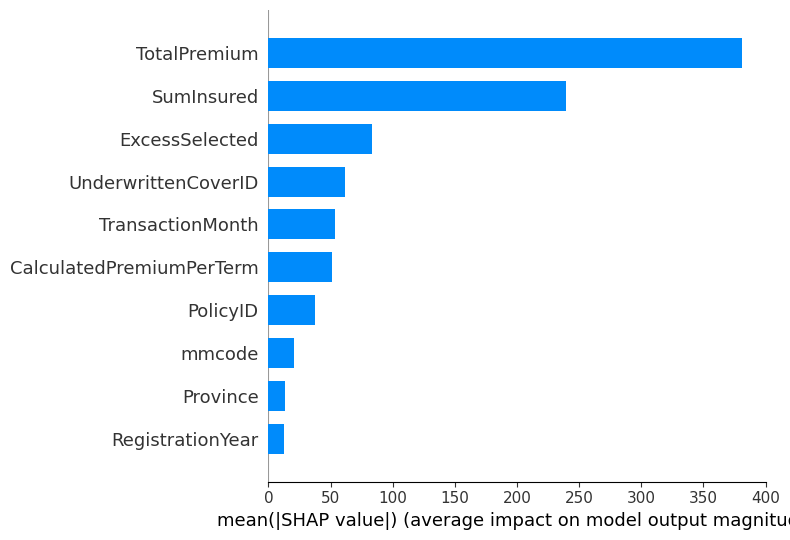

In [25]:
# Produce a SHAP summary plot (bar) of mean absolute SHAP value per feature
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", max_display=10)


In [26]:
import numpy as np

# Compute mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Get top indices
top_indices = np.argsort(mean_abs_shap)[::-1][:5]
top_features = feature_names[top_indices]
top_importances = mean_abs_shap[top_indices]

for feat, imp in zip(top_features, top_importances):
    print(f"{feat}: {imp:.3f}")


TotalPremium: 380.954
SumInsured: 239.197
ExcessSelected: 83.419
UnderwrittenCoverID: 61.244
TransactionMonth: 53.572


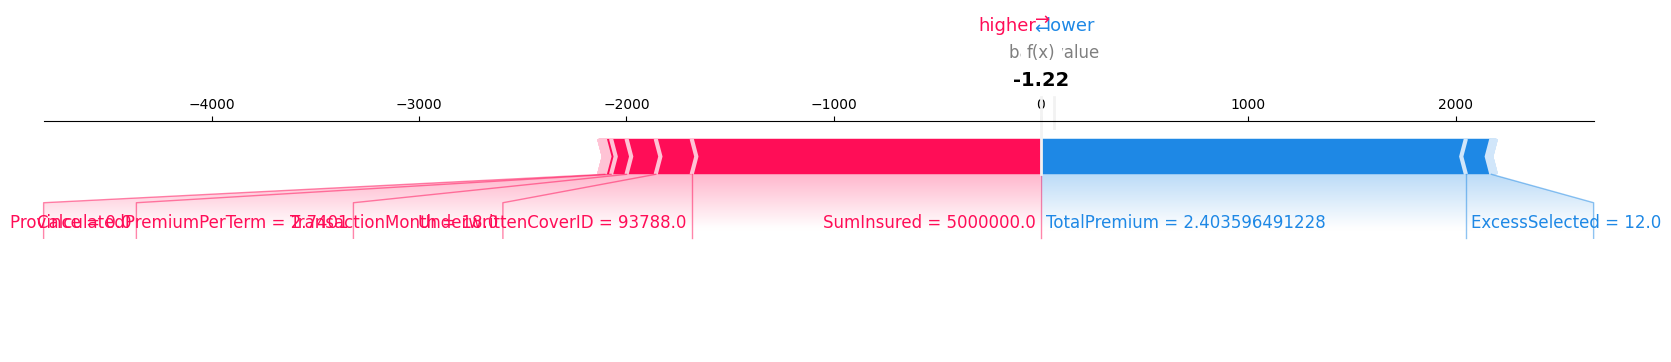

In [27]:
import shap

# Explainer and shap_values already created with your model and sample data
# Select one sample (e.g., index 0)
idx = 0
shap.force_plot(explainer.expected_value, shap_values[idx], X_sample.iloc[idx], matplotlib=True)


In [26]:
print(X_train.shape, y_train.shape)
print(X_train.dtypes)
print(y_train.dtype)
print(X_train.isnull().sum().sum(), y_train.isnull().sum())


(2230, 40) (80,)
UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Citizenship                  object
LegalType                    object
Title                        object
Language                     object
AccountType                  object
MaritalStatus                object
Gender                       object
Country                      object
Province                     object
ItemType                     object
mmcode                      float64
VehicleType                  object
RegistrationYear              int64
make                         object
Model                        object
Cylinders                   float64
cubiccapacity               float64
kilowatts                   float64
bodytype                     object
NumberOfDoors               float64
VehicleIntroDate             object
AlarmImmobiliser             object
TrackingDevice               object
NewVehicle 

In [29]:
from sklearn.model_selection import train_test_split

# Use 20% test data, and fix random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


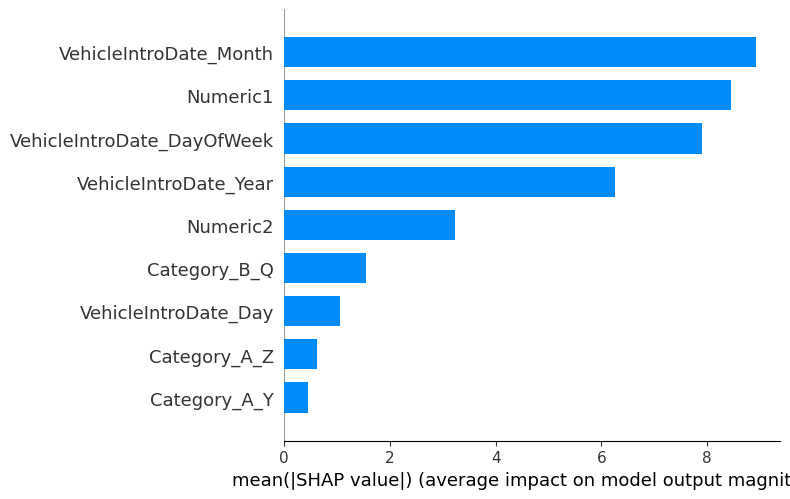

Top 5 important features for Decision Tree by SHAP value:
VehicleIntroDate_Month: 8.927
Numeric1: 8.452
VehicleIntroDate_DayOfWeek: 7.898
VehicleIntroDate_Year: 6.256
Numeric2: 3.227


In [31]:
import shap

# Initialize TreeExplainer for your Decision Tree model
explainer_dt = shap.TreeExplainer(dt)

# Calculate SHAP values for your test set X_test (make sure it's a DataFrame)
shap_values_dt = explainer_dt.shap_values(X_test)

# Summary plot (bar plot for mean absolute SHAP values)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

# Compute mean absolute SHAP values to find top features
import numpy as np
mean_abs_shap_dt = np.abs(shap_values_dt).mean(axis=0)

# Get top 5 important features
top_indices_dt = np.argsort(mean_abs_shap_dt)[::-1][:5]
top_features_dt = X_test.columns[top_indices_dt]
top_importances_dt = mean_abs_shap_dt[top_indices_dt]

print("Top 5 important features for Decision Tree by SHAP value:")
for feat, imp in zip(top_features_dt, top_importances_dt):
    print(f"{feat}: {imp:.3f}")


In [36]:
df_model = df_encoded.copy()  # or whatever DataFrame you're using for modeling


In [38]:
print(df_model.columns)


Index(['UnderwrittenCoverID', 'PolicyID', 'IsVATRegistered', 'PostalCode',
       'mmcode', 'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts',
       'NumberOfDoors',
       ...
       'CoverType_Third Party', 'CoverType_Windscreen',
       'CoverGroup_Credit Protection', 'CoverGroup_Deposit Cover',
       'CoverGroup_Income Protector', 'CoverGroup_Motor Comprehensive',
       'Section_Motor Comprehensive', 'Section_Optional Extended Covers',
       'Product_Mobility Commercial Cover: Monthly',
       'Product_Mobility Metered Taxis: Monthly'],
      dtype='object', length=635)


In [40]:
df_targets = df[['TotalClaims', 'TotalPremium']].copy()
df_encoded['TotalClaims'] = df_targets['TotalClaims']
df_encoded['TotalPremium'] = df_targets['TotalPremium']



In [41]:
X = df_encoded.drop(columns=['TotalClaims', 'TotalPremium'])
y_class = (df_encoded['TotalClaims'] > 0).astype(int)
y_severity = df_encoded['TotalClaims']


In [42]:
from sklearn.model_selection import train_test_split

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X and y_class are your feature matrix and binary target

# 1. Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

# 2. Initialize and train Random Forest classifier
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls, y_train_cls)

# 3. Predict on test set
y_pred_cls = rf_cls.predict(X_test_cls)

# 4. Evaluate performance
acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)

print(f"✅ Accuracy: {acc:.2f}")
print(f"✅ Precision: {prec:.2f}")
print(f"✅ Recall: {rec:.2f}")
print(f"✅ F1 Score: {f1:.2f}")


✅ Accuracy: 1.00
✅ Precision: 1.00
✅ Recall: 1.00
✅ F1 Score: 1.00


In [49]:
# Create binary target for claim occurrence
df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)

# Select features for classification (drop target and other unwanted columns)
# For example, drop TotalClaims and TotalPremium etc.
features = df.drop(columns=['TotalClaims', 'TotalPremium', 'ClaimOccurred'])

# If you want, select only numeric columns or encode categoricals
X_cls = features  # You might need encoding here
y_cls = df['ClaimOccurred']

# If you have categorical features, encode them before train_test_split:
# Example using one-hot encoding (pandas get_dummies):
X_cls_encoded = pd.get_dummies(X_cls)

# Now split:
from sklearn.model_selection import train_test_split

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls_encoded, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"Train shape: {X_train_cls.shape}, Test shape: {X_test_cls.shape}")
print(f"Train labels distribution:\n{y_train_cls.value_counts(normalize=True)}")
print(f"Test labels distribution:\n{y_test_cls.value_counts(normalize=True)}")



Train shape: (800078, 1899), Test shape: (200020, 1899)
Train labels distribution:
ClaimOccurred
0    0.997213
1    0.002787
Name: proportion, dtype: float64
Test labels distribution:
ClaimOccurred
0    0.99721
1    0.00279
Name: proportion, dtype: float64


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_cls = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_cls.fit(X_train_cls, y_train_cls)

# Predict
y_pred_cls = rf_cls.predict(X_test_cls)
y_proba_cls = rf_cls.predict_proba(X_test_cls)[:, 1]

# Evaluate
print(classification_report(y_test_cls, y_pred_cls))
print(f"AUC-ROC: {roc_auc_score(y_test_cls, y_proba_cls):.3f}")



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199462
           1       0.11      0.01      0.01       558

    accuracy                           1.00    200020
   macro avg       0.56      0.50      0.51    200020
weighted avg       0.99      1.00      1.00    200020

AUC-ROC: 0.657


In [ ]:
import shap

explainer_cls = shap.TreeExplainer(rf_cls)
shap_values_cls = explainer_cls.shap_values(X_test_cls)

shap.summary_plot(shap_values_cls[1], X_test_cls, plot_type="bar")  # Class 1 = claim occurrence

# Print top 5 features by mean absolute SHAP value
import numpy as np
mean_abs_shap_cls = np.abs(shap_values_cls[1]).mean(axis=0)
top_indices_cls = np.argsort(mean_abs_shap_cls)[::-1][:5]
top_features_cls = X_test_cls.columns[top_indices_cls]
top_importances_cls = mean_abs_shap_cls[top_indices_cls]

print("Top 5 important features (classification):")
for feat, imp in zip(top_features_cls, top_importances_cls):
    print(f"{feat}: {imp:.3f}")

